In [1]:
from diffusers import StableDiffusionXLPipeline, DiffusionPipeline
import torch
from PIL import Image
import os

In [2]:
def generate_image(
    model_path,
    prompt,
    num_inference_steps=50,
    guidance_scale_base=7,
    guidance_scale_refiner=4,
    high_noise_frac = 0.9,
    seed=None,
    height=1024,
    width=1024,
):    
    # Set random seed if provided
    if seed is not None:
        torch.manual_seed(seed)
        
    # Load the fine-tuned model
    base = DiffusionPipeline.from_pretrained(
        model_path,
        torch_dtype=torch.float16,
        use_safetensors=True
    ).to("cuda")

    refiner = DiffusionPipeline.from_pretrained(
        "stabilityai/stable-diffusion-xl-refiner-1.0",
        text_encoder_2=base.text_encoder_2,
        vae=base.vae,
        torch_dtype=torch.float16,
        use_safetensors=True,
        variant="fp16",
    )
    refiner.to("cuda")
    
    # Generate the image
    image = base(
        prompt=prompt,
        num_inference_steps=num_inference_steps,
        denoising_end=high_noise_frac,
        guidance_scale=guidance_scale_base,
        output_type="latent",
        height=height,
        width=width
    ).images
    image = refiner(
        prompt=prompt,
        num_inference_steps=num_inference_steps,
        denoising_start=high_noise_frac,
        guidance_scale=guidance_scale_refiner,
        image=image,
        height=height,
        width=width
    ).images[0]
        
    # Clear GPU memory
    del base
    del refiner
    torch.cuda.empty_cache()
    
    return image

In [3]:
model_path = "/workspace/fine_tuned_sdxl_style"
prompt = """
       in the style of HFdesign, A beautifully hand-drawn Easter rabbit decoration in a whimsical illustrated style. Full body.
       The lines are slightly sketchy with smooth, painterly textures, evoking a warm and artistic aesthetic. The colors are vibrant yet slightly soft, blending like traditional colored pencil or watercolor artwork.
       The background is plain white for product display.
    """

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

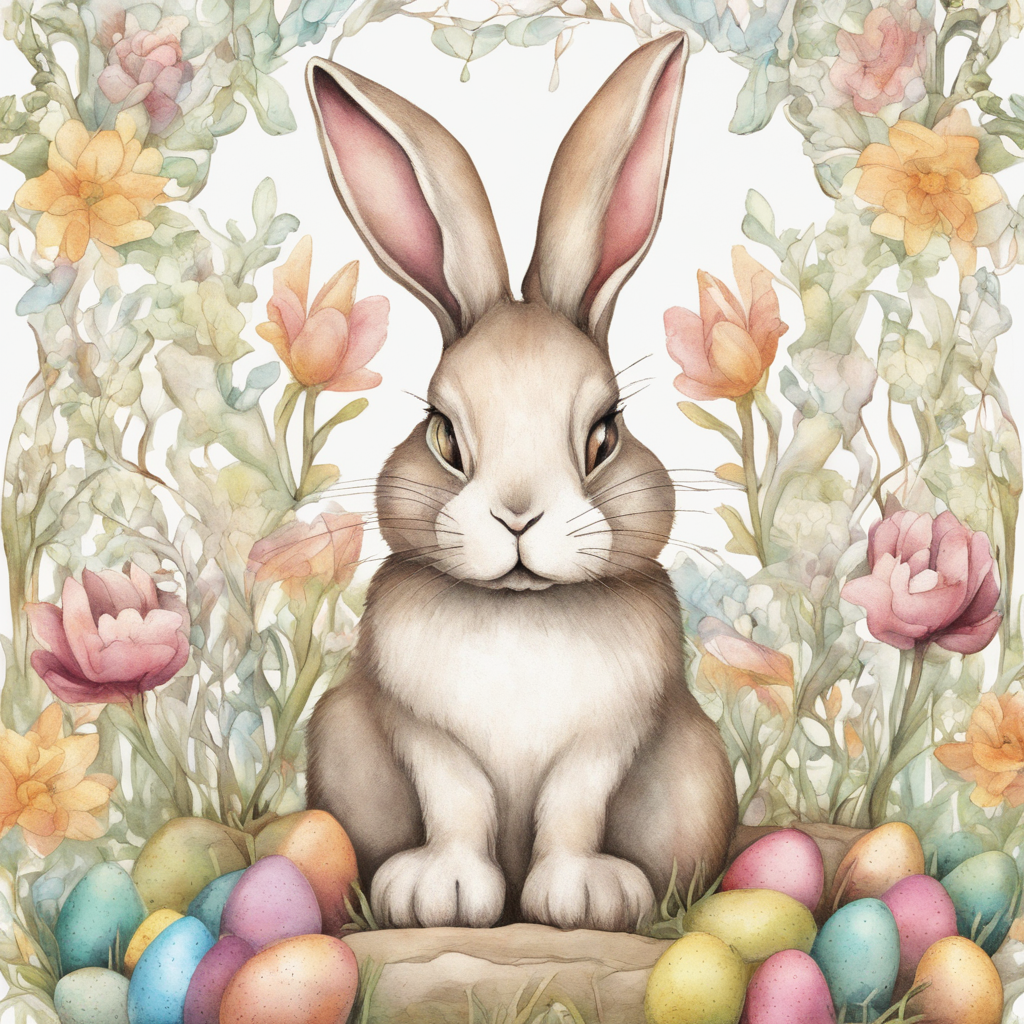

In [4]:
generate_image(
    model_path=model_path,
    prompt=prompt,
    num_inference_steps=40,
    guidance_scale_base=7,
    guidance_scale_refiner=4,
    high_noise_frac=0.9,
    height=1024,
    width=1024,
)

In [10]:
def push_to_hub(
    model_path,
    repo_id,
    token=None,
    private=False,
):
    try:
        print("Pushing model to hub...")
        # Push the model
        pipeline = StableDiffusionXLPipeline.from_pretrained(
            model_path,
            torch_dtype=torch.float32,
            use_safetensors=True
        )
        
        # Push to hub
        pipeline.push_to_hub(
            repo_id,
            private=private,
            safe_serialization=True,
        )
        
        print(f"Successfully pushed model to: https://huggingface.co/{repo_id}")
        
    except Exception as e:
        print(f"Error pushing to hub: {str(e)}")
        raise

In [ ]:
push_to_hub(
    model_path="/workspace/fine_tuned_sdxl_style",
    repo_id="ebony59/sdxl-hf-style-4epoch",
    private=False
)

Pushing model to hub...


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/2.78G [00:00<?, ?B/s]

diffusion_pytorch_model-00001-of-00002.safetensors:   0%|          | 0.00/9.99G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

diffusion_pytorch_model-00002-of-00002.safetensors:   0%|          | 0.00/282M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Upload 5 LFS files:   0%|          | 0/5 [00:00<?, ?it/s]